In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import *
import pandas as pd
import math
import obspy

In [72]:
0.5/100e6

5e-09

In [57]:
.01/1e8

1e-10

In [58]:
.005/5e8

1.0000000000000001e-11

### <b> 1. strain rate due to lithospheric cooling </b>

<b> Parameters. </b>

1. Seismogenic layer thickness <b> Ls </b>. Currently using Ls = elastic lithosphere thickness. Estimates of elastic lithosphere thickness from <a href = "https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JE006756"> Borelli et al. 2021 </a> estimate ∼10–40 km based on studying steep-sided domes,  <a href = "https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020JE006783"> Russell and johnson (2021) </a> 4-9 km from their study of a dome at the edge of Aramatiti corona; they also report regional values in the range of 10-20 km, <a href = "https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013JE004455"> McGovern et al. </a> used a range of 5-60 km in their models of lithospheric flexure near volcanoes and domes, <a href = "https://academic.oup.com/gji/article/119/2/627/699161?login=true"> Johnson and Sandwell (1994) </a> also estimate depths to the base of the mechanically strong layer of about 20-80 km at different locations; estimated elastic thickness in the range of 12-34 km.

2. Shear modulus <b>shear_mod </b>. Mars papers use between 30 - 70 GPa. here, shear_mod = 50 GPa (<a href = "https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JB091iB01p00403"> Banerdt 1986 </a>)

3. Volumetric thermal expansion coefficient <b> alpha </b>. Typical values between 2e-5 and 3.3e-5. Using alpha = 3e-5 here.

4. Planetary radius <b> Rp </b>. Rp = 6051.8 km.

5. Cooling rate <b> cooling_rate </b>. <font color='red'> Unsure how to calculate. Currently using 0.001/0.5 Myr = 2e-8  (should I use 1e-10 or 1e-11) </font>

6. maximum moment observable on Venus is assumed to be magnitue mw = 7

7. minimum moment of interest is magnitude mw = 1

In [33]:
## function definitions
def moment2magnitude(m0):
    mw = 2/3 * (np.log10(m0) - 9.1)
    return mw

def moment2surmagnitude(m0):
    ms = np.log10(m0*.001)-19.46
    return ms

def magnitude2moment(mw):
    m0 = np.power(10, (3/2 *mw + 9.1))
    return m0

def cumulative_moment(strain_rate, seis_volume, shear_mod = 50e9, seis_efficiency=1, time = 365.25*24*60*60):
    Mcum = seis_efficiency * strain_rate * seis_volume * shear_mod * time
    return Mcum

def adot_parameter(strainrate, seisvolume, shear_mod = 50e9, m0_max=1e20, beta = 0.67):
    adot = (1-beta)/beta * np.power(m0_max, beta-1) * strainrate * shear_mod * seisvolume 
    return adot

def numevents_year(m0_min, m0_max, adot, beta=0.67):
    numevents = adot * (np.power(m0_min, -beta) - np.power(m0_max, -beta))
    return numevents

def num_events_moment(m0_range, m0_col):
    if type(m0_col) != np.ndarray:
        m0_arr = m0_col.to_numpy()
    else:
        m0_arr = m0_col
    num_events_list = []
    for m0 in m0_range:
        num_events_list.append(np.count_nonzero(np.where(m0_arr>m0)))
    return np.array(num_events_list)

In [68]:
## strain rate due to lithospheric contraction

Ls = 40                ## in km
Rp = 6051.8            ## in km
alpha = 3e-5           ## volumetric thermal expansion coefficient in /K
cooling_rate = 5e-10   ## in K/yr
shear_mod = 50e9       ## in Pa

## volume of seismogenic layer
V = (4/3) * np.pi * Rp**3 - (Rp-Ls)**3                       ## in km3


## strain rate due to cooling of the lithosphere in s-1 (formula from equation 8 of Knapmeyer et al. (2006) (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006JE002708)

strainrate_lith =  ((alpha* cooling_rate * V) / (4*np.pi*Ls*(Rp - Ls/2)**2))/(365.25*24*60*60)              ## dividing by a factor of 365.25*24*60*60 to convert strain rate/yr to strain rate/s
print("the strain rate due to lithospheric contraction per second is = ", '{:.2e}'.format(strainrate_lith)) 


## cumulative moment
Mcum = cumulative_moment(strainrate_lith, V*1e9, shear_mod = shear_mod)
print("the cumulative moment is = ", '{:.2e}'.format(Mcum))

the strain rate due to lithospheric contraction per second is =  1.85e-20
the cumulative moment is =  2.07e+19


### <b> 2. strain rate due to dynamic uplift and subsidence </b>

<b> Parameters. </b>

1. mantle / background / ambient density <b> rho_0 </b>. rho_0 =  3300 kg/m3            (<a href = "https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JE004237"> James et al. 2013 </a>, table 4) 
2. mantle / background / ambient temperature <b> T_0 </b>. T_0 =  1450 deg C            (this value was used in <a href = "https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JE004237"> James et al. 2013 </a>, I think)
3. average excess plume temperature <b> del_T </b>. del_T = 200
4. plume head thickness <b> H </b>. H = 200 km
5. Young's modulus <b> E </b>. E = 60 GPa       (<a href = "https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JE004237"> James et al. 2013 </a>, table 4)  
6. acceleration due to gravity <b> g </b>. g = 8.87
7. heating / uplift duration scale <b> plume_time </b>. plume_time = 300 Myr. <a href = "https://www.nature.com/articles/s41561-020-0606-1"> Gulcher et al. (2020) </a> mention "The typical model evolution time in our experiments, measured from rising plume to fully cooled and recrystallized plume material, is only a few tens of millions of years (20–55 Myr)" under Venus's global geodynamics section.


If you need to calculate surface uplift (U) due o plume, use the equations from publications below. 
Equations from Rudge et al. 2008 (https://www.sciencedirect.com/science/article/pii/S0012821X07007674?via%3Dihub), eq. 2 and Frazer & Korenaga 2022 (https://www.sciencedirect.com/science/article/pii/S0012821X21005422), eq. 6 used.
Uplift rates - (https://www.nature.com/articles/ngeo1191#MOESM305, https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007TC002106)

In [63]:
## strain rate due to plume induced uplift / upwelling

rho_0 =  3300          ## mantle / background density in kg / m3
T_0 =  1450            ## mantle / background / ambient temperature in deg C (from James et al.)
E = 60e9               ## Young's moduls in Pa
g = 8.87               ## acceleration due to gravity in m/s2
H = 100                ## plume thickness in km - average of swell diamters in Stofan et al. 1995 divided by a plume aspect ratio of 0.08 (https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/95JE01834)
del_T = 250            ## average excess temperature of the plume in deg C / K
plume_time = 50e6     ## rate of heating / cooling 

## uplift in km
# U = H * alpha * (del_T) / (1 - alpha*(T_0+273))
print(H* alpha * del_T )

## strain rate due to plume induced vertical motion in s-1  (formula from Phillips 1991)
strainrate_plume = (rho_0 * g * H*1e3 * alpha * del_T / plume_time) / E / (365.25*24*60*60)        ## dividing by a factor of 365.25*24*60*60 to convert strain rate/yr to strain rate/s
print("the strain rate due to a single plume induced uplift per second is = ", '{:.2e}'.format(strainrate_plume)) 

0.75
the strain rate due to a single plume induced uplift per second is =  2.32e-19


In [64]:
## cumulative moment
Mtotal = cumulative_moment(strainrate_lith+strainrate_plume, V*1e9, shear_mod = shear_mod)
print("the cumulative moment is = ", '{:.2e}'.format(Mtotal))

the cumulative moment is =  2.33e+21


### 2.1 number of plumes and plume properties on venus
<a href= "https://www.sciencedirect.com/science/article/pii/S0019103511003563#f0005"> Smrekar and Sotin (2012) </a> point out that there is evidence for 9 deep mantle plumes at various locations on Venus based on GTR. 


In [65]:
## code for strain rate due to multiple plume induced uplift and subsidnce acroos planet

## need to think about number of plumes, and plume thicknesses and range of plume duration

### <b> 3. expected number of quakes in a year </b>

In [66]:
strainrate_total = strainrate_lith  #+ strainrate_plume

beta = 0.67          ##(Phillips 1991)
m0_max = magnitude2moment(7)    ## in Nm
m0_min = magnitude2moment(1)
print(m0_min)

num = 11
m0_range = np.geomspace(m0_min, m0_max, num=num)

adot = adot_parameter(strainrate_total, V*1e9, shear_mod = shear_mod, m0_max=m0_max )

num_events = []
for mom in m0_range:
    rr = numevents_year(mom, m0_max, adot, beta)
    num_events.append(rr)
    

events_arr = np.zeros((num, 3))
events_arr[:,0] = moment2magnitude(m0_range)
events_arr[:,1] = m0_range
events_arr[:,2] = np.array(num_events)

print(events_arr)
print(events_arr[:,2] * (365.25*24*60*60))
print(events_arr[:,2] * (120*24*60*60))

39810717055.34969
[[1.00000000e+00 3.98107171e+10 8.71245632e-01]
 [1.60000000e+00 3.16227766e+11 2.17339866e-01]
 [2.20000000e+00 2.51188643e+12 5.42168780e-02]
 [2.80000000e+00 1.99526231e+13 1.35243035e-02]
 [3.40000000e+00 1.58489319e+14 3.37315537e-03]
 [4.00000000e+00 1.25892541e+15 8.40855300e-04]
 [4.60000000e+00 1.00000000e+16 2.09149059e-04]
 [5.20000000e+00 7.94328235e+16 5.15639537e-05]
 [5.80000000e+00 6.30957344e+17 1.22528563e-05]
 [6.40000000e+00 5.01187234e+18 2.44633071e-06]
 [7.00000000e+00 3.98107171e+19 0.00000000e+00]]
[2.74944212e+07 6.85872455e+06 1.71095455e+06 4.26794562e+05
 1.06448688e+05 2.65353752e+04 6.60024235e+03 1.62723462e+03
 3.86670739e+02 7.72003260e+01 0.00000000e+00]
[9.03307471e+06 2.25337973e+06 5.62120591e+05 1.40219979e+05
 3.49728749e+04 8.71798775e+03 2.16845745e+03 5.34615072e+02
 1.27037614e+02 2.53635568e+01 0.00000000e+00]


### <b> results from Insight models </b>

In [37]:
## Knapmeyer et al. seismic moment values
Mw = [1,2,3,4,5,6,7, 7.6]
M0 = [4e10, 1.3e12, 4e13, 1.3e15, 4e16, 1.3e18, 4e19, 3.2e20]
strongfew  = [38*60, 5.5*60*60, 1.9*24*60*60 , 17.1*24*60*60, 148*24*60*60, 3.6*365.25*24*60*60, 30.3*365.25*24*60*60, 115*365.25*24*60*60]
strongmany = [72, 10.5*60, 1.5*3600, 13.1*60*60]
medium = [48.5*60, 7*60*60, 2.5*24*3600, 21.8*24*3600, 189*24*3600, 4.5*365.25*24*3600]
weakmany = [2.5*3600, 21.9*3600, 7.9*24*3600, 68.5*24*3600]
weakfew = [3.9*24*3600, 33.5*24*3600, 290*24*3600, 6.7*365.25*24*3600, 50*365.25*24*3600, 516*365.25*24*3600, 4500*365.25*24*3600, 17000*365.25*24*3600]

knapmeyer_arr = np.zeros((len(M0), 7))
knapmeyer_arr[:,0] = Mw
knapmeyer_arr[:,1] = M0
knapmeyer_arr[0:len(strongfew),2] = strongfew
knapmeyer_arr[0:len(strongmany),3] = strongmany
knapmeyer_arr[0:len(medium),4] = medium
knapmeyer_arr[0:len(weakfew),5] = weakfew
knapmeyer_arr[0:len(weakmany),6] = weakmany



## Golombek sesimic moments 2002
M0 = np.geomspace(1e10, 1e20, 11)
M0 = np.delete(M0, 1)

mb = np.array([1,2.2,2.8,3.4,4,4.6,5.2,5.8,6.4,7])
Gol_rec_rates19 = np.array([14*60, 3.7*3600, 15*3600, 2.5*24*3600, 9.8*24*3600, 1.3*30*24*3600, 5*30*24*3600, 1.7*365.25*24*3600, 6.7*365.25*24*3600, 27*365.25*24*3600])
Gol_rec_rates18 = np.array([2.4*3600, 37*3600, 6.2*24*3600, 24.7*24*3600, 3.2*30*24*3600, 1.1*365.25*24*3600, 4.3*365.25*24*3600, 17*365.25*24*3600, 68*365.25*24*3600,269*365.25*24*3600])
Gol_rec_rates17 = np.array([1*24*3600, 15*24*3600, 2*30*24*3600, 8.1*30*24*3600, 2.7*365.25*24*3600, 10.7*365.25*24*3600, 43*365.25*24*3600, 170*365.25*24*3600, 678*365.25*24*3600, 2698*365.25*24*3600])
golombek_arr = np.zeros((len(Gol_rec_rates19), 5))
golombek_arr[:,0] = mb
golombek_arr[:,1] = M0
golombek_arr[:,2] = Gol_rec_rates19
golombek_arr[:,3] = Gol_rec_rates18
golombek_arr[:,4] = Gol_rec_rates17



## Golombek sesimic moments 1992
mw = np.array([1.3, 2.2, 3.1, 4, 4.9, 5.8, 6.7])
power = np.array([17.5, 19, 20.5, 22, 23.5, 25, 26.5])
M0 = np.zeros_like(mw)
for i in range(len(power)):
    M0[i] = math.pow(10, power[i]-7)
# M0 = np.power(10, np.array([17.5, 19, 20.5, 22, 23.5, 25, 26.5])) * 1e-7
Gol92_rec_rates = np.array([52*24*3600, 1*365.25*24*3600, 9*365.25*24*3600, 71*365.25*24*3600, 565*365.25*24*3600, 4484*365.25*24*3600, 35587*365.25*24*3600])
Gol92_rec_rates = np.array([1.2*3600, 9.8*3600, 3.3*24*3600, 0.9*30*24*3600, 6.8*30*24*3600, 4.5*365.25*24*3600, 35.6*365.25*24*3600])
golombek92_arr = np.zeros((len(Gol92_rec_rates), 3))
golombek92_arr [:,0] = mw
golombek92_arr [:,1] = M0
golombek92_arr [:,2] = Gol92_rec_rates



## Phillips 1991 rates
M0 = np.geomspace(1e14, 1e19, 6)
Phillips_rec_rates_int = np.array([200, 42.8, 9.15, 1.96, 0.42, 0.09])
Phillips_rec_rates = np.cumsum(Phillips_rec_rates_int[::-1])[::-1] 
phillips_arr = np.zeros((len(Phillips_rec_rates_int), 2))
phillips_arr[:,0] = M0
phillips_arr[:,1] = Phillips_rec_rates

### <b> harvard catalog </b>

In [38]:
cmtfile = "jan76_dec20.ndk"

f = open(cmtfile, "r")
d = f.readlines()
# print(f.readline())
f.close()

In [39]:
earth_mom = []
for i in range(len(d)):
    if i%5 == 3:
        exp = int(d[i][0:2])               
    if i%5 == 4:
        scalar_mom = float(d[i][49:56])
        earth_mom.append(scalar_mom * math.pow(10, exp-7))              ## including a -7 factor for conversion from dyn-cm to N-m

In [40]:
print(np.min(earth_mom), np.max(earth_mom), np.mean(earth_mom), len(earth_mom))

3490000000000000.0 5.312e+22 5.876186871674408e+18 56832


In [41]:
# mom = mom[mom > 0]
M0_earth = np.geomspace(1e15, 1e22, 7)
print(M0_earth)
num_events_earth = []
for min_mom in M0_earth:
    num_events_earth.append(np.count_nonzero(np.where(earth_mom>min_mom)))
num_events_earth = np.array(num_events_earth)
num_events_earth_year = num_events_earth / (2020-1976)
print(num_events_earth_year)

[1.00000000e+15 1.46779927e+16 2.15443469e+17 3.16227766e+18
 4.64158883e+19 6.81292069e+20 1.00000000e+22]
[1.29161364e+03 1.28545455e+03 3.87681818e+02 6.75909091e+01
 1.08636364e+01 1.34090909e+00 9.09090909e-02]


In [42]:
cmt_intra_df = pd.read_csv("cmt_data/cmt_out5degPB_dep50km.csv")
cmt_intra_mom = cmt_intra_df.moment
num_events_earth_intra_year = num_events_moment(M0_earth, cmt_intra_mom) / (2020-1976)

### <b> InSight catalog </b>

In [15]:
cat_insight = obspy.read_events("http://ds.iris.edu/files/insight/v11/events_extended_multiorigin_v11_2022-04-01.xml", format="QUAKEML")
cat2_insight = cat_insight.filter("magnitude >= 0.0")

## sorts catalog by time - current v11 catalogtime range: 2019-03-14 to 2022-03-14
# cat_sorted = cat2_insight.copy()
# cat_sorted.events = sorted(cat2_insight, key=lambda x: x.preferred_origin().time, reverse=False)

In [16]:
m0_list = []
mw_list = []
for event in cat2_insight.events:
    for magnitude in event.magnitudes:
        if magnitude.magnitude_type == "MW":
            mw = magnitude.mag
            m0 = np.power(10, (1.5 * mw + 9.1))
            mw_list.append(mw)
            m0_list.append(m0)
m0_insight = np.array(m0_list)
M0_mars_categ = [4e10, 1.3e12, 4e13, 1.3e15, 4e16, 1.3e18, 4e19, 3.2e20]
num_events_insight_year = num_events_moment(M0_mars_categ, m0_insight) / 3
print(num_events_insight_year)

[216.          45.66666667   8.66666667   1.           0.
   0.           0.           0.        ]


### <b> Venera 14 - Ksanfomaliti et al. 1983 </b>
2 events with amplitudes slighly les than and greater that 80 * 10^-6 cm observed about 3000 km away during 57 minutes of operation.
magnitude = log10(amplitude) + 2.76log10(epicentral_distance)-2.48

In [17]:
mag = np.log10(80e-6) #+ 2.76 * np.log(3000/6051.8) - 2.48

/tmp/ipykernel_168/22712626.py:9: RuntimeWarning: divide by zero encountered in divide
  ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,3], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_strongmany")
/tmp/ipykernel_168/22712626.py:11: RuntimeWarning: divide by zero encountered in divide
  ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,4], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_medium")
/tmp/ipykernel_168/22712626.py:13: RuntimeWarning: divide by zero encountered in divide
  ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,6], "s-" , c = "black", markerfacecolor='none', markersize = markersize, label = "Mars (Knapmeyer et al., 2006)") #, label = "knapmeyer_weakfew")


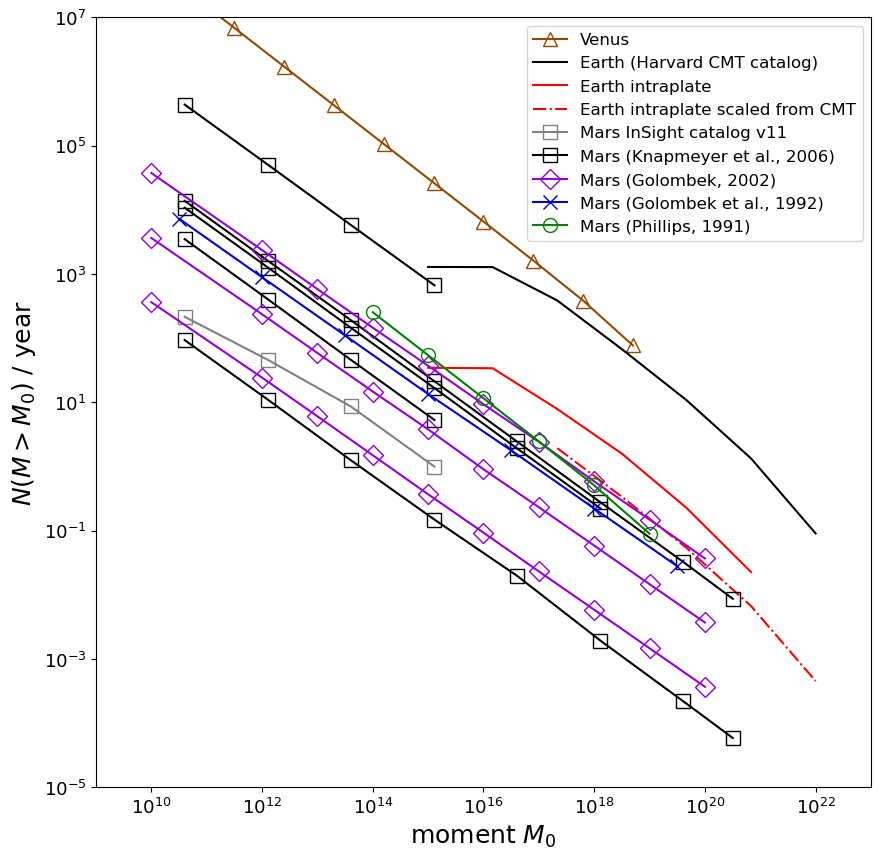

In [67]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
markersize = 10

ax.plot(events_arr[:-1,1],(365.25*24*60*60)*events_arr[:-1,2], "^-", label = "Venus", c='#924900', markerfacecolor='none', markersize = markersize)
ax.plot(M0_earth, num_events_earth_year, "-", label= "Earth (Harvard CMT catalog)", c='k', markersize = markersize)
ax.plot(M0_earth[:-1], num_events_earth_intra_year[:-1], "-", label= "Earth intraplate", c='red')
ax.plot(M0_earth[2:], num_events_earth_year[2:]*0.005, "-.", label= "Earth intraplate scaled from CMT", c='red')
ax.plot(M0_mars_categ[0:4], num_events_insight_year[0:4], "s-" , c = "grey", markerfacecolor='none', markersize = markersize, label = "Mars InSight catalog v11")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,3], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_strongmany")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,2], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_strongfew")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,4], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_medium")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,5], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_weakmany")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,6], "s-" , c = "black", markerfacecolor='none', markersize = markersize, label = "Mars (Knapmeyer et al., 2006)") #, label = "knapmeyer_weakfew")
ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,2], "D-" , c= "darkviolet", markerfacecolor='none', markersize = markersize) #, label = "Golombek (2002)")
ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,3], "D-" , c= "darkviolet", markerfacecolor='none', markersize = markersize) #, label = "Golombek (2002)")
ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,4], "D-" , c= "darkviolet", markerfacecolor='none', markersize = markersize, label = "Mars (Golombek, 2002)") #, label = "Golombek (2002)")
ax.plot(golombek92_arr[:,1], (365.25*24*60*60)/golombek92_arr[:,2], "x-" , c= "mediumblue", markersize = markersize, label = "Mars (Golombek et al., 1992)")
ax.plot(phillips_arr[:,0], phillips_arr[:,1], "o-" , c= "green", markerfacecolor='none', markersize = markersize, label = "Mars (Phillips, 1991)")
# ax.set_xlim(m0_range[0], m0_range[-1])
ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10)
ax.set_xlim(1e9, 1e23)
ax.set_ylim(1e-5, 1e7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=12)
ax.set_xlabel("moment " + r'$M_0$', fontsize=18)
ax.set_ylabel(r'$ N (M>M_0)$' +" / year", fontsize=18)
# plt.savefig("venus_seismicity_estimates.png")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
markersize = 10

ax.plot(events_arr[:-1,1],(365.25*24*60*60)*events_arr[:-1,2], "^-", label = "Venus", c='#924900', markerfacecolor='none', markersize = markersize)
ax.plot(M0_earth, num_events_earth_year, "-", label= "Earth (Harvard CMT catalog)", c='k', markersize = markersize)
ax.plot(M0_earth[2:], num_events_earth_year[2:]*0.005, "-.", label= "Earth Intraplate scaled", c='red')
ax.plot(M0_earth[:-1], num_events_earth_intra_year[:-1], "-", label= "Earth Intraplate", c='red')
ax.plot(M0_mars_categ[0:4], num_events_insight_year[0:4], "s-" , c = "grey", markerfacecolor='none', markersize = markersize, label = "Mars Insight catalog v11")
# ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,3], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_strongmany")
# ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,2], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_strongfew")
# ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,4], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_medium")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,5], "s-" , c = "black", markerfacecolor='none', markersize = markersize) #, label = "knapmeyer_weakmany")
# ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,6], "s-" , c = "black", markerfacecolor='none', markersize = markersize, label = "Mars (Knapmeyer et al., 2006)") #, label = "knapmeyer_weakfew")
ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,2], "D-" , c= "darkviolet", markerfacecolor='none', markersize = markersize) #, label = "Golombek (2002)")
ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,3], "D-" , c= "darkviolet", markerfacecolor='none', markersize = markersize) #, label = "Golombek (2002)")
ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,4], "D-" , c= "darkviolet", markerfacecolor='none', markersize = markersize, label = "Mars (Golombek, 2002)") #, label = "Golombek (2002)")
ax.plot(golombek92_arr[:,1], (365.25*24*60*60)/golombek92_arr[:,2], "x-" , c= "mediumblue", markersize = markersize, label = "Mars (Golombek et al., 1992)")
ax.plot(phillips_arr[:,0], phillips_arr[:,1], "o-" , c= "green", markerfacecolor='none', markersize = markersize, label = "Mars (Phillips, 1991)")
# ax.set_xlim(m0_range[0], m0_range[-1])
ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10)
ax.set_xlim(1e9, 1e23)
ax.set_ylim(1e-5, 1e7)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=12)
ax.set_xlabel(r'$M_0$', fontsize=18)
ax.set_ylabel(r'$ N (M>M_0) / year$', fontsize=18)
plt.savefig("venus_seismicity_estimates.png")
plt.show()